# Set-up

## Imports

In [57]:
# Standard
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import sys
import os
sys.path.append(os.path.abspath('..')) # for importing from python files not in the same directory

# Plotting
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300
from matplotlib.cm import Blues
import seaborn as sns
sns.set_theme()
colors = sns.color_palette("deep")
from tqdm.notebook import tqdm, trange
import plotly.graph_objects as go

# Sci-kit learn imports
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression

# statsmodels
from statsmodels.tsa.stattools import adfuller

# Custom
%load_ext autoreload
%autoreload explicit
%aimport probability_calibration, utils
from probability_calibration import calibrate_proba_monthly_recal
from utils import vertically_concatenate_images

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

In [61]:
scope = 'OFF'

model = 'RF'
extension = '.pkl'
input_path = f'../data/2_processed/ML_dataset_{scope}.pkl'
predictions_path = f'{scope}/model_predictions/{model}_predicted_probs_monthly_recal_rolling_12m{extension}'
cal_save_folder = f'{scope}/model_dumps/calibrator'

start_month = 202001
end_month = 202212

subsample_size = None

target = 'Result'

## Functions

In [62]:
def AUCPR(groupby):
    return average_precision_score(groupby[target], groupby['y_probs'])

def Precision(groupby):
    return precision_score(groupby[target], (groupby['y_probs'] >= 0.5))

def Recall(groupby):
    return recall_score(groupby[target], (groupby['y_probs'] >= 0.5))

def F1(groupby):
    return f1_score(groupby[target], (groupby['y_probs'] >= 0.5))

In [63]:
def get_score_per_group(
        df,
        group,
        score=AUCPR,
        plot=True,
        plot_kind='bar',
        plot_trend=False,
        hide_xlab=True,
        plot_baseline=False,
        ylab=None,
        save_fig=False,
        **kwargs
    ):
    score_df = df.groupby(group, as_index=False).apply(score).rename({None: score.__name__}, axis=1)
    score_df.sort_values(group, inplace=True)
    score_df[group[0]] = score_df[group[0]].astype(str)
    if plot:
        fig, ax = plt.subplots()
        if len(group) > 1:
            score_df.pivot(index=group[0], columns=group[1], values=score.__name__).plot(kind='bar', ax=ax, **kwargs)
        else:
            score_df.set_index(group[0]).plot(kind=plot_kind, legend=False, ax=ax, **kwargs)
        if plot_trend:
            mean_score = score_df[score.__name__].mean()
            ax.axhline(y=mean_score, linestyle='--', color='red', linewidth=1)
            # Add annotation for correlation coefficient
            ax.annotate('$\mu = {:.2f}$'.format(mean_score), xy=(0.78, 0.81), xycoords='axes fraction',  
            xytext=(20, 20), textcoords='offset points',  fontsize=14, color='red')
        if plot_baseline:
            ax1 = ax.twinx()
            rate_df = df.groupby(group, as_index=False)["Result"].mean()
            rate_df[group[0]] = rate_df[group[0]].astype(str)
            ax1.plot(rate_df[group[0]], rate_df.Result, color='black', linewidth=1, markersize=3, label='Prior probability')
            ax1.set_ylabel('Prior probability')
            ax1.set_ylim((0, 0.06))
            ax.grid(False)
            ax1.grid(False)
        if hide_xlab:
            plt.xlabel(None)
        plt.xticks(rotation=0)
        if ylab:
            plt.ylabel(ylab)
        else:
            plt.ylabel(score.__name__)
        # plt.ylim((0,1))
        ax.set_ylim((0, 1))
        # plt.title('{} bids APS per {}'.format(scope, group[0]))
        # plt.tight_layout()
        if save_fig:
            plt.savefig('../plots/{}/precision_recall/{}_{}_{}_{}.png'.format(scope, model, score.__name__, '_'.join(group), scope.lower()), bbox_inches='tight')
        plt.show()

    return score_df

In [64]:
def get_acc_rate_per_group(df, group, plot=True, save_fig=False, **kwargs):
    rate_df = df.groupby(group, as_index=False)["Result"].mean()
    rate_df[group[0]] = rate_df[group[0]].astype(str)
    if plot:
        if len(group) > 1:
            rate_df.pivot(index=group[0], columns=group[1], values="Result").plot(kind='bar', **kwargs)
        else:
            rate_df.set_index(group[0]).plot(kind='bar', legend=False, **kwargs)
        plt.xlabel(group[0])
        plt.xticks(rotation=0)
        plt.ylabel('Acceptance rate')
        plt.title('{} bids acceptance rate per {}'.format(scope, group[0]))
        plt.tight_layout()
        if save_fig:
            plt.savefig('../plots/{}/{}_acc_{}_{}.png'.format(scope, model, '_'.join(group), scope.lower()))
        plt.show()

    return rate_df

# Main

## Load dataset & model predictions

In [ ]:
# Load dataset
input_df = pd.read_pickle(input_path)
df = input_df.copy()
# Select only observations for which we generated a prediction
df['yearmonth'] = df.index.str[:6].astype(int)
df['month'] = df.index.str[4:6].astype(int)
df['Month'] = pd.PeriodIndex(year=df['year'], month=df['month'], freq='M')
df

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,PVold,PVnew,Price,PriceDiff,Result,RatioAcc,Qty,yearmonth,month,Month
201801011UP_ALTOADDA_1_OFF,1,20180101,2018,UP_ALTOADDA_1,OFF,1.023687,0.433872,-3.072079,-0.745118,0.717989,...,0.000,0.000,111.74,0.419,False,0.0,195.500,201801,1,2018-01
201801012UP_ALTOADDA_1_OFF,2,20180101,2018,UP_ALTOADDA_1,OFF,0.787333,0.214727,-3.269953,-0.389639,0.717989,...,0.000,0.000,111.74,0.433,False,0.0,195.500,201801,1,2018-01
201801013UP_ALTOADDA_1_OFF,3,20180101,2018,UP_ALTOADDA_1,OFF,1.142582,0.517246,-3.511562,-0.682966,0.717989,...,0.000,0.000,111.74,0.451,False,0.0,195.500,201801,1,2018-01
201801014UP_ALTOADDA_1_OFF,4,20180101,2018,UP_ALTOADDA_1,OFF,1.359091,0.692018,-3.635374,-0.274023,0.717989,...,0.000,0.000,111.74,0.480,False,0.0,195.500,201801,1,2018-01
201801015UP_ALTOADDA_1_OFF,5,20180101,2018,UP_ALTOADDA_1,OFF,1.640151,0.729753,-3.703611,-0.167476,1.093151,...,0.000,0.000,111.74,0.513,False,0.0,195.500,201801,1,2018-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022123117UP_VOGHERA_1_OFF,17,20221231,2022,UP_VOGHERA_1,OFF,0.237656,-2.008471,-1.806319,0.875068,-2.527147,...,0.540,0.540,320.00,0.066,False,0.0,181.509,202212,12,2022-12
2022123121UP_VOGHERA_1_OFF,21,20221231,2022,UP_VOGHERA_1,OFF,-0.075154,-0.954465,-1.872673,0.745683,-2.449869,...,0.573,0.573,320.00,0.016,False,0.0,169.432,202212,12,2022-12
2022123122UP_VOGHERA_1_OFF,22,20221231,2022,UP_VOGHERA_1,OFF,2.244316,-3.847872,-2.345759,0.833482,-2.547642,...,0.526,0.526,320.00,0.085,False,0.0,188.000,202212,12,2022-12
2022123123UP_VOGHERA_1_OFF,23,20221231,2022,UP_VOGHERA_1,OFF,2.277886,-3.849805,-2.698679,0.834434,-2.527069,...,0.525,0.525,320.00,0.190,False,0.0,189.000,202212,12,2022-12


In [66]:
# Load model predictions
if extension == '.csv':
    y_probs = pd.read_csv(predictions_path, index_col=0)
else:
    y_probs = pd.read_pickle(predictions_path)
# Below some obs could be dropped as NA as they were not in the prediction process
df['y_probs'] = y_probs

## Calibration curves

In [67]:
test_df = df[(df.yearmonth >= start_month) & (df.yearmonth <= end_month)]
test_df['y_probs_cal'] = calibrate_proba_monthly_recal(df, start_month, end_month, save_folder=cal_save_folder)
# Sometimes the isotonic regression creates na so in this case we simply take the uncalibrated y
cal_is_na = test_df.y_probs_cal.isna()
test_df.loc[cal_is_na, 'y_probs_cal'] = test_df.loc[cal_is_na, 'y_probs']
print(f"{cal_is_na.sum()} observations have a NaN calibrated value. For these observations, y_probs_cal was set to y_probs.")

100%|██████████| 36/36 [00:03<00:00,  9.06it/s]


6 observations have a NaN calibrated value. For these observations, y_probs_cal was set to y_probs.


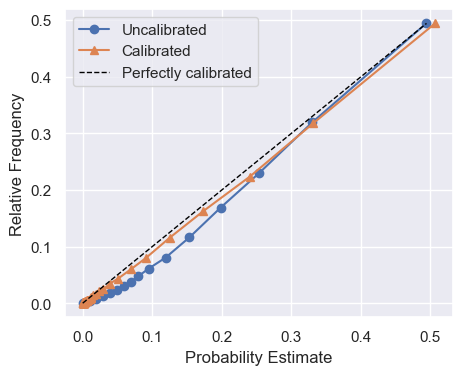

In [68]:
n_bins = 50
plt.figure(figsize=(5,4))
prob_true, prob_pred = calibration_curve(test_df.Result, test_df.y_probs, n_bins=n_bins, strategy='quantile')
plt.plot(prob_pred, prob_true, marker='o', label='Uncalibrated', color=colors[0])

prob_true_cal, prob_pred_cal = calibration_curve(test_df.Result, test_df.y_probs_cal, n_bins=n_bins, strategy='quantile')
plt.plot(prob_pred_cal, prob_true_cal, label='Calibrated', marker='^', color=colors[1])

plt.plot(prob_pred, prob_pred, color='black', linestyle='dashed', label='Perfectly calibrated', linewidth=1)

plt.xlabel('Probability Estimate')
plt.ylabel('Relative Frequency')
plt.legend()

plt.savefig(f"../plots/{scope}/rd_{scope}.png", bbox_inches='tight') 

In [69]:
test_df.y_probs_cal.to_pickle(f'{scope}/model_predictions/{model}_predicted_probs_monthly_recal_rolling_12m_CALIBRATED.pkl')

## Performance analysis

### Overall performance per year

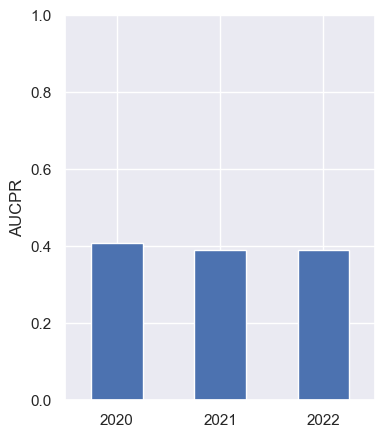

In [70]:
aps_df = get_score_per_group(test_df, group=['year'], figsize=(4,5))

In [71]:
aps_df

,year,AUCPR
0,2020,0.407727
1,2021,0.388073
2,2022,0.389151


### Overall performance per hour

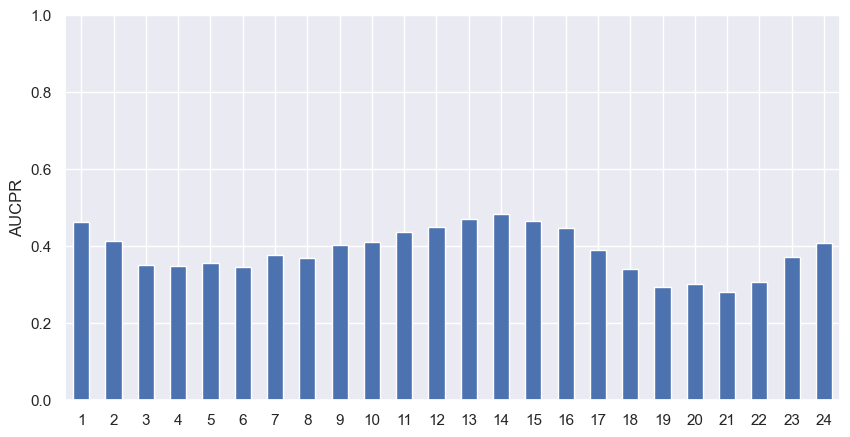

,hour,AUCPR
0,1,0.462684
1,2,0.411605
2,3,0.351299
3,4,0.347462
4,5,0.356215
5,6,0.344264
6,7,0.377148
7,8,0.368610
8,9,0.400844
9,10,0.408745


In [72]:
aps_df = get_score_per_group(test_df, group=['hour'], figsize=(10,5))
aps_df

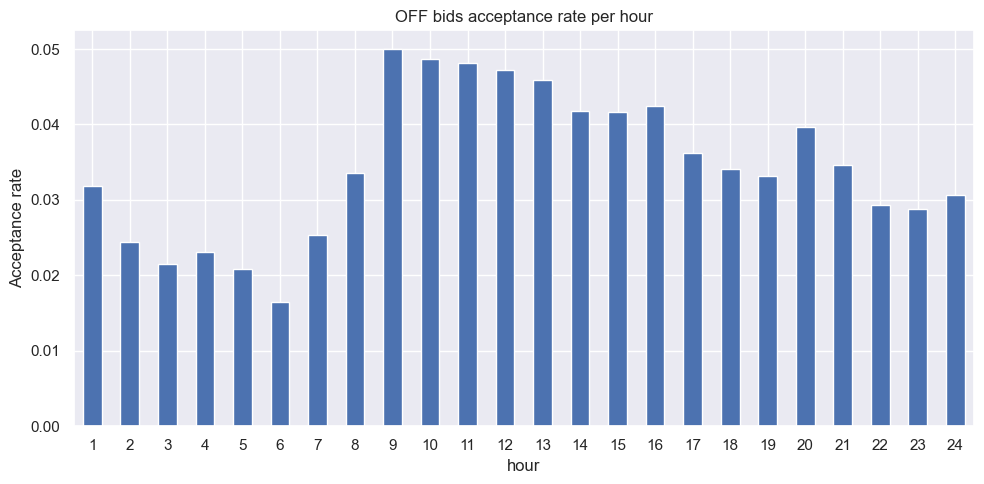

,hour,Result
0,1,0.031851
1,2,0.024439
2,3,0.021539
3,4,0.023060
4,5,0.020861
5,6,0.016512
6,7,0.025401
7,8,0.033524
8,9,0.049967
9,10,0.048714


In [73]:
acc_df = get_acc_rate_per_group(test_df, ["hour"], figsize=(10,5))
acc_df

So it seems that it is the acceptance rate is not really driving the variability in the performance of the model

### Overall performance per month

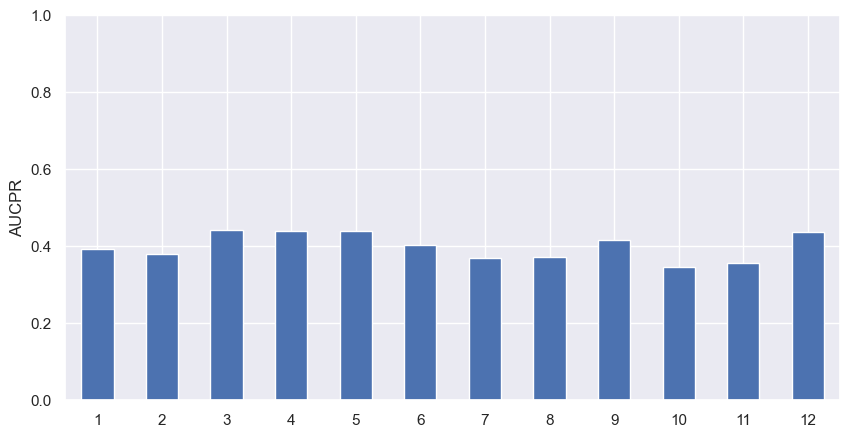

,month,AUCPR
0,1,0.392246
1,2,0.378668
2,3,0.441050
3,4,0.437486
4,5,0.439000
5,6,0.402488
6,7,0.368297
7,8,0.371134
8,9,0.414979
9,10,0.345369


In [74]:
aps_df = get_score_per_group(test_df, group=['month'], figsize=(10,5))
aps_df

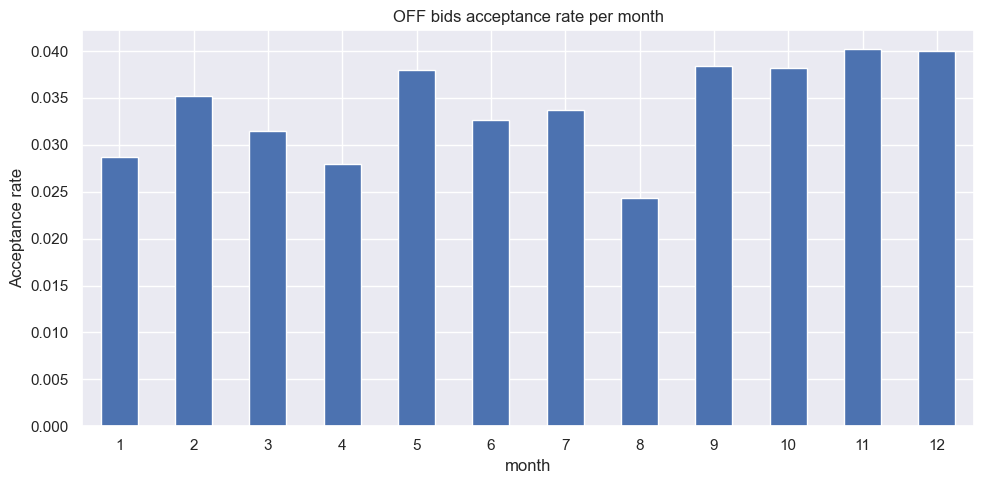

,month,Result
0,1,0.028729
1,2,0.035222
2,3,0.031483
3,4,0.027977
4,5,0.038009
5,6,0.032643
6,7,0.033763
7,8,0.024366
8,9,0.038446
9,10,0.038139


In [75]:
acc_df = get_acc_rate_per_group(test_df, ["month"], figsize=(10,5))
acc_df

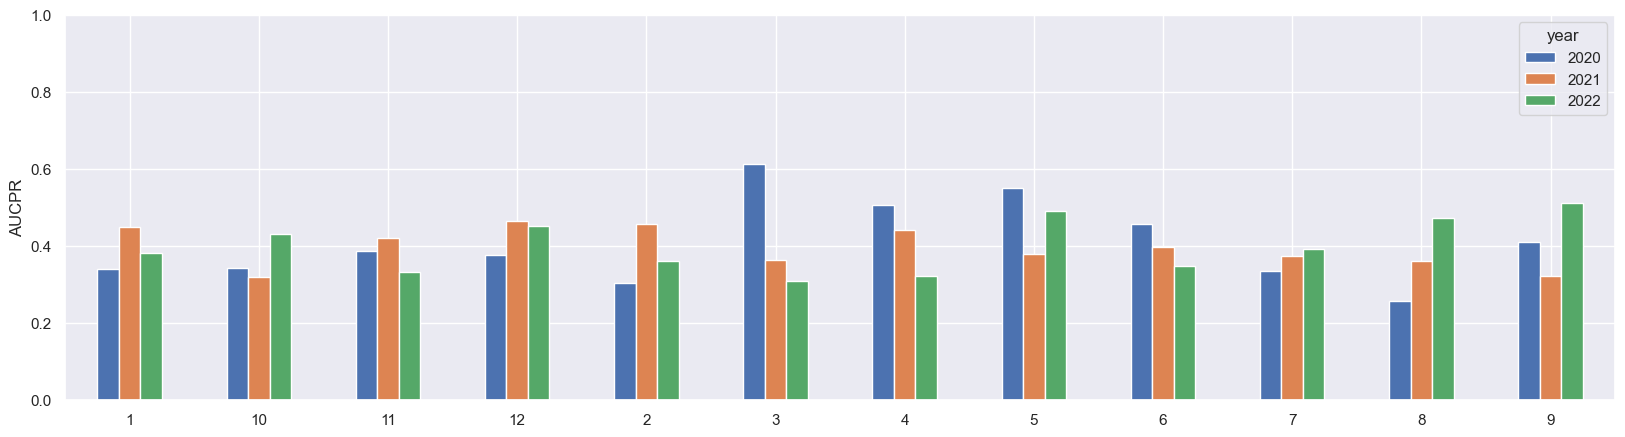

In [76]:
aps_df = get_score_per_group(test_df, group=['month', 'year'], figsize=(20,5))

### Overall performance per technology

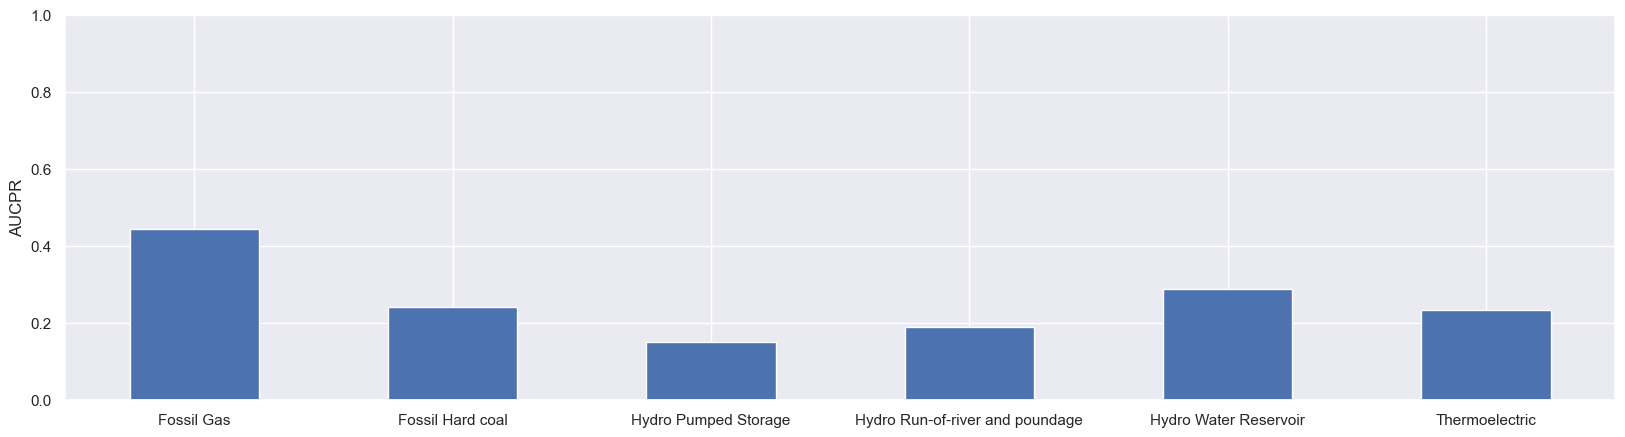

,Tech,AUCPR
0,Fossil Gas,0.443743
1,Fossil Hard coal,0.241941
2,Hydro Pumped Storage,0.151373
3,Hydro Run-of-river and poundage,0.188296
4,Hydro Water Reservoir,0.288239
5,Thermoelectric,0.233680


In [77]:
aps_df = get_score_per_group(test_df, group=['Tech'], figsize=(20,5))
aps_df

In [78]:
test_df.Tech.value_counts()

Tech
Fossil Gas                         594139
Hydro Water Reservoir              556626
Hydro Pumped Storage               360426
Hydro Run-of-river and poundage    236769
Thermoelectric                     127221
Fossil Hard coal                   113350
Name: count, dtype: int64

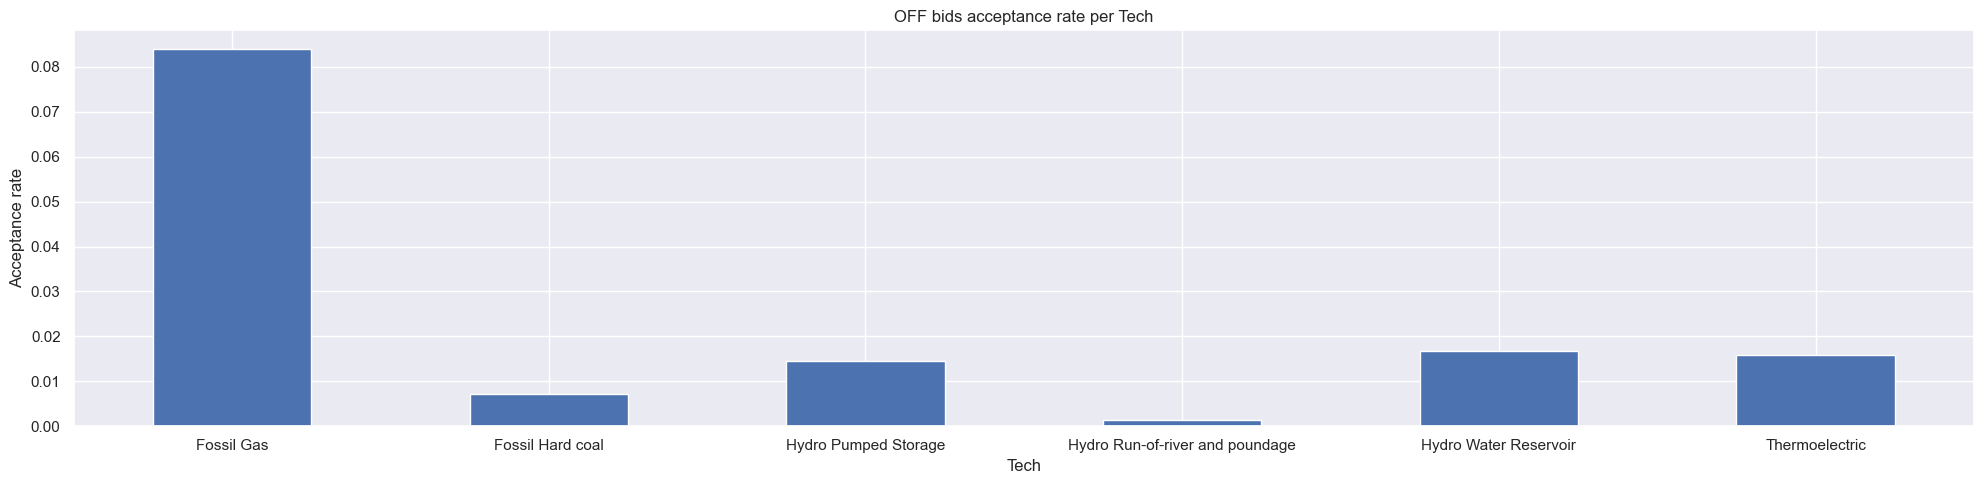

In [79]:
acc_df = get_acc_rate_per_group(test_df, ["Tech"], figsize=(20,5))

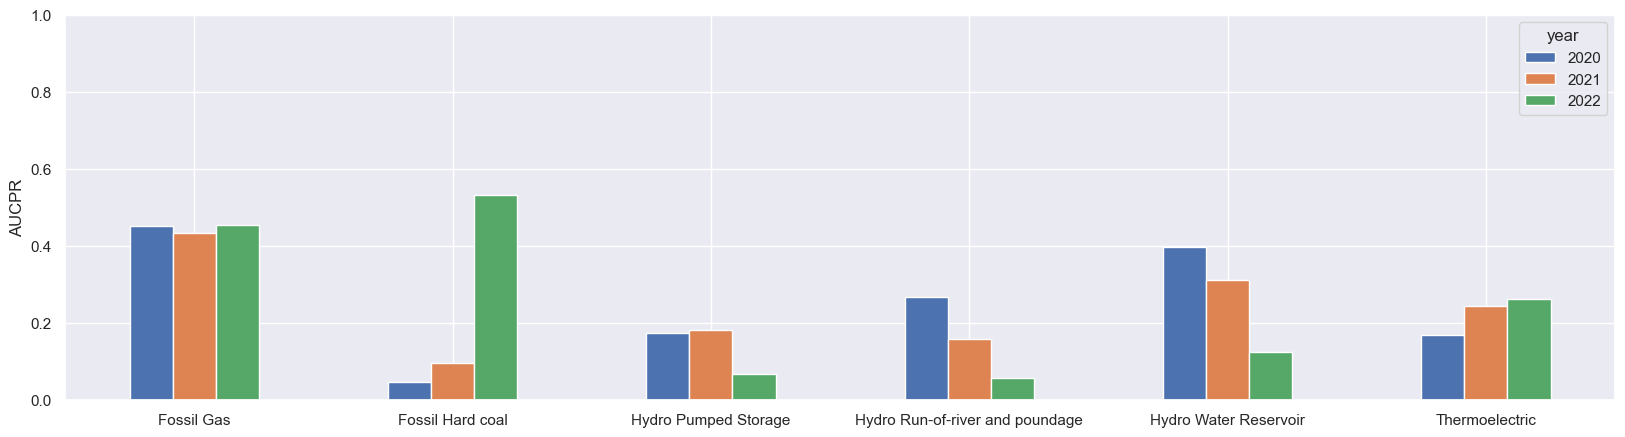

In [80]:
aps_df = get_score_per_group(test_df, group=['Tech', 'year'], figsize=(20,5))

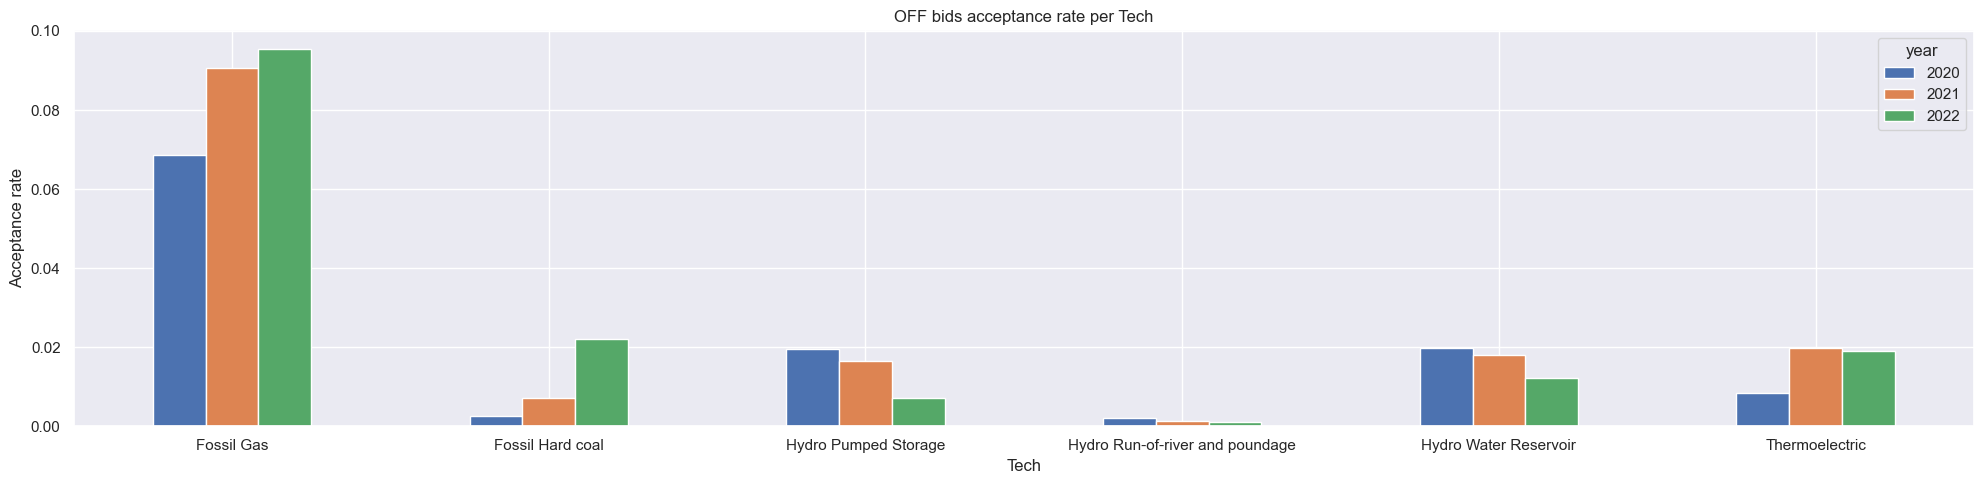

In [81]:
acc_df = get_acc_rate_per_group(test_df, ["Tech", "year"], figsize=(20,5))

### Time series of monthly performance

From now on the probability calibration matters and we set `y_probs` to `y_probs_cal`

In [82]:
test_df['y_probs'] = test_df['y_probs_cal']
test_df.drop('y_probs_cal', axis=1, inplace=True)

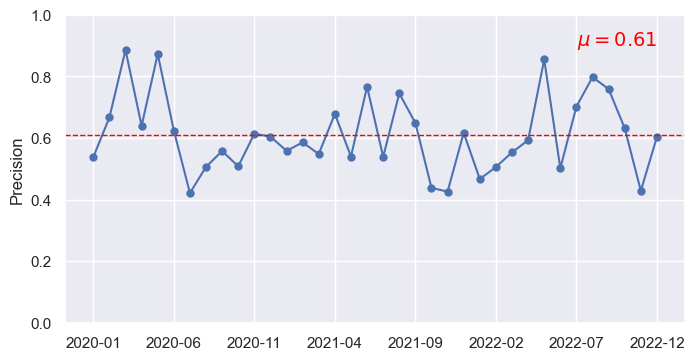

In [84]:
precision_df = get_score_per_group(test_df, score=Precision, group=['Month'], plot_kind='line', figsize=(8,4), marker='o', markersize=5, plot_trend=True, save_fig=True)

In [85]:
adfuller(precision_df.Precision)

(-3.6739769750425966,
 0.004494442715244493,
 10,
 25,
 {'1%': -3.7238633119999998, '5%': -2.98648896, '10%': -2.6328004},
 -34.123884995420894)

array([[<Axes: title={'center': 'Precision'}>]], dtype=object)

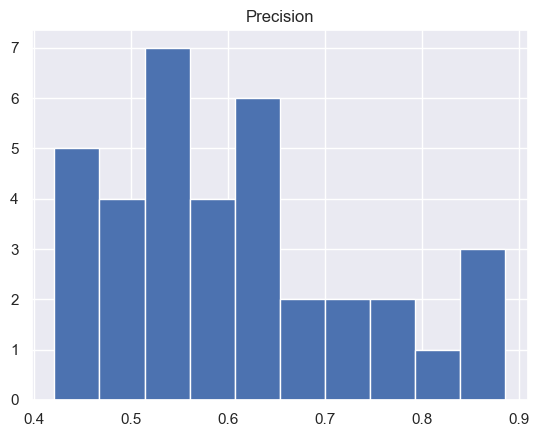

In [86]:
precision_df.hist()

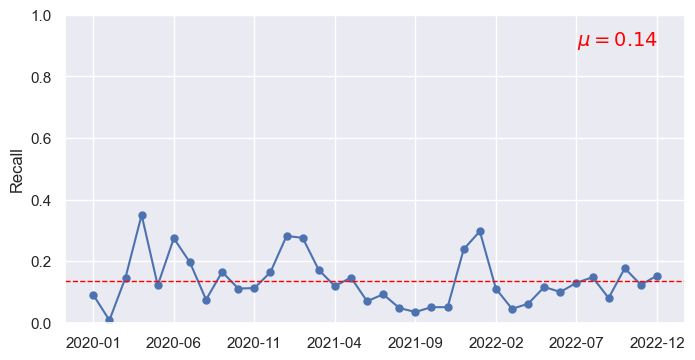

In [87]:
recall_df = get_score_per_group(test_df, score=Recall, group=['Month'], plot_kind='line', plot_trend=True, figsize=(8,4), marker='o', markersize=5, save_fig=True)

In [88]:
adfuller(recall_df.Recall)

(-3.997353096392525,
 0.0014244348114401495,
 1,
 34,
 {'1%': -3.639224104416853,
  '5%': -2.9512301791166293,
  '10%': -2.614446989619377},
 -63.25140390009685)

array([[<Axes: title={'center': 'Recall'}>]], dtype=object)

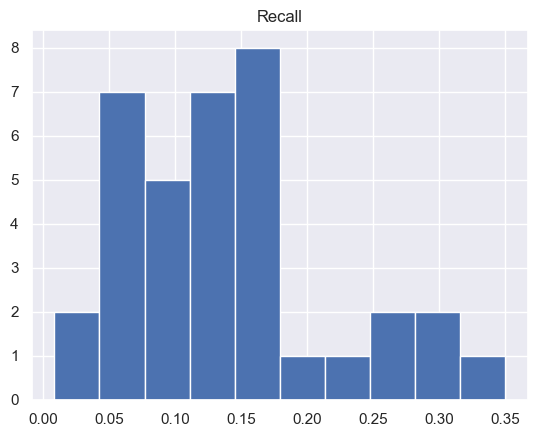

In [89]:
recall_df.hist()

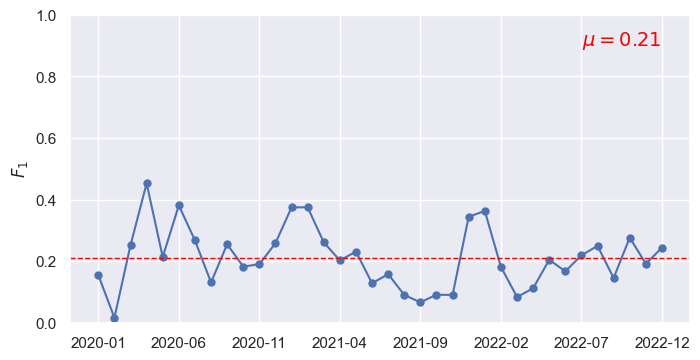

In [90]:
f1_df = get_score_per_group(test_df, score=F1, group=['Month'], plot_kind='line', figsize=(8,4), plot_trend=True, ylab='$F_1$', marker='o', markersize=5, save_fig=True)

In [91]:
adfuller(f1_df.F1)

(-4.024382563352849,
 0.001288082965972634,
 0,
 35,
 {'1%': -3.6327426647230316,
  '5%': -2.9485102040816327,
  '10%': -2.6130173469387756},
 -51.39151491828122)

array([[<Axes: title={'center': 'F1'}>]], dtype=object)

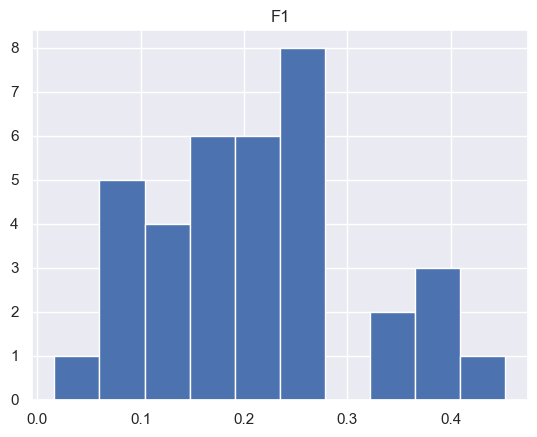

In [92]:
f1_df.hist()

Combine images together using utils function

In [94]:
images_path = ['../plots/{}/precision_recall/{}_{}_Month_{}.png'.format(scope, model, score, scope.lower()) for score in ['Precision', 'Recall', 'F1']]
output_path = '../plots/{}/precision_recall/prf1_{}.png'.format(scope, scope.lower())

vertically_concatenate_images(images_path, output_path)

# clean
for img in images_path:
    os.remove(img)

<HR>

# TESTS